# 09-2 순환 신경망으로 IMDB 리뷰 분류하기

## IMDB 리뷰 데이터셋

일반적으로 영어 문장은 모두 소문자로 바꾸고 구둣점을 삭제한 다음 공백을 기준으로 분리합니다. 이렇게 분리된 단어를 **토큰**toekn이라고 부릅니다.

토큰에 할당하는 정수 중에 몇 개는 특정한 용도로 예약되어 있는 경우가 많습니다. 예를 들어 0은 패딩, 1은 문장의 시작, 2는 어휘 산전에 없는 토큰을 나타냅니다.

In [1]:
from tensorflow.keras.datasets import imdb
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=300)

In [2]:
train_input.shape, test_input.shape

((25000,), (25000,))

이 데이터는 개별 리뷰를 담은 파이썬 리스트 객체로 이루어진 넘파이 배열입니다.

In [3]:
len(train_input[0])

218

첫 번째 리뷰의 길이느 218개의 토큰으로 이루어져 있습니다.

In [4]:
len(train_input[1])

189

첫 번째 리뷰에 담긴 내용을 출력해 보죠

In [5]:
train_input[0]

[1,
 14,
 22,
 16,
 43,
 2,
 2,
 2,
 2,
 65,
 2,
 2,
 66,
 2,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 2,
 112,
 50,
 2,
 2,
 9,
 35,
 2,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 2,
 2,
 39,
 4,
 172,
 2,
 2,
 17,
 2,
 38,
 13,
 2,
 4,
 192,
 50,
 16,
 6,
 147,
 2,
 19,
 14,
 22,
 4,
 2,
 2,
 2,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 2,
 38,
 76,
 15,
 13,
 2,
 4,
 22,
 17,
 2,
 17,
 12,
 16,
 2,
 18,
 2,
 5,
 62,
 2,
 12,
 8,
 2,
 8,
 106,
 5,
 4,
 2,
 2,
 16,
 2,
 66,
 2,
 33,
 4,
 130,
 12,
 16,
 38,
 2,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 2,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 2,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 2,
 15,
 256,
 4,
 2,
 7,
 2,
 5,
 2,
 36,
 71,
 43,
 2,
 2,
 26,
 2,
 2,
 46,
 7,
 4,
 2,
 2,
 13,
 104,
 88,
 4,
 2,
 15,
 297,
 98,
 32,
 2,
 56,
 26,
 141,
 6,
 194,
 2,
 18,
 4,
 226,
 22,
 21,
 134,
 2,
 26,
 2,
 5,
 144,
 30,
 2,
 18,
 51,
 36,
 28,
 224,
 92,
 25,
 104,
 4,
 226,
 65,
 16,
 38,
 2,
 88,
 12,
 16,
 283,
 5,
 16,
 2,
 113,
 103,
 

앞서 num_words=300으로 지정했지 때문에 어휘 사전에는 300게의 단어만 들어가 있습니다. 따라서 어휘 사전에 없는 단어는 모두 2로 표시되어 나타납니다.

이번에는 타깃 데이터를 출력해 보겠습니다.

In [6]:
train_target[:20]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1],
      dtype=int64)

해결할 문제는 리뷰가 긍정인지 부정인지를 판단하는 겁니다. 그러면 이진 분류 문제로 불 수 있으므로 타깃값이 0(부정)과 1(긍정)로 나누어집니다.

훈련 세트에서 검증 세트를 떼어 놓도록 하죠

In [7]:
from sklearn.model_selection import train_test_split
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

먼저 각 리뷰의 길이를 계산해 넘파이 배열에 담겠습니다. 이렇게 하는 이유는 평균적인 리뷰의 길이와 가장 짧은 리뷰의 길이 그리고 가장 긴 리뷰의 길이를 확인하고 싶기 때문입니다. 이를 위해 넘파이 리스트 내포를 사용해 train_input의 원소를 순회하면서 길이를 재도록 하겠습니다.

In [8]:
import numpy as np
lengths = np.array([len(x) for x in train_input])

lengths 배열이 준비되었으므로 넘파이 mean() 함수와 median() 함수를 사용해 리뷰 길이의 평균과 중간값을 구해 보겠습니다.

In [9]:
np.mean(lengths), np.median(lengths)

(239.00925, 178.0)

lengths 배열을 히스토그램으로 표현해 보겠습니다.

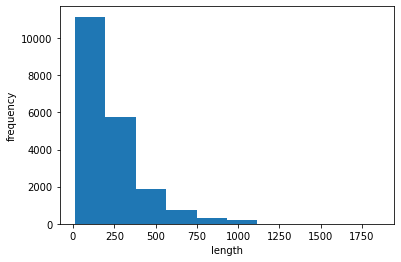

In [10]:
import matplotlib.pyplot as plt
plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

역시 한쪽으로 치우쳤군요. 대부분의 리뷰 길이는 300 미만입니다.

리뷰는 대부분 짧아서 이 예제에서는 중간값보다 훨씬 작은 100개의 단어만 사용하겠습니다. 하지만 여전히 100개의 단어보다 작은 리뷰가 있습니다. 이런 리뷰들이 길이를 100에 맞추기 위해 패딩이 필요합니다. 보통 패딩을 나타내는 토큰으로는 0을 사용합니다.

케라스는 시퀀스 데이터의 길이를 맞추는 pad_sequences() 함수를 제공합니다. 이 함수를 사용해 train_input의 길이를 100으로 맞추어 보겠습니다.

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)

maxlen에 원하는 길이를 지정하면 이보다 긴 경우는 잘라내고 짧은 경우는 0으로 패딩합니다.

In [12]:
train_seq.shape

(20000, 100)

In [13]:
train_seq[0]

array([ 10,   4,  20,   9,   2,   2,   2,   5,  45,   6,   2,   2,  33,
       269,   8,   2, 142,   2,   5,   2,  17,  73,  17, 204,   5,   2,
        19,  55,   2,   2,  92,  66, 104,  14,  20,  93,  76,   2, 151,
        33,   4,  58,  12, 188,   2, 151,  12, 215,  69, 224, 142,  73,
       237,   6,   2,   7,   2,   2, 188,   2, 103,  14,  31,  10,  10,
         2,   7,   2,   5,   2,  80,  91,   2,  30,   2,  34,  14,  20,
       151,  50,  26, 131,  49,   2,  84,  46,  50,  37,  80,  79,   6,
         2,  46,   7,  14,  20,  10,  10,   2, 158])

이 새플의 앞뒤에 패딩 값 0이 없는 것으로 보아 100보다는 길었을 것 같습니다. 그럼 원래 샘플의 앞 부분이 잘렸을까요? 뒷부분이 잘렸을까요? train_input에 있는 원본 샘플의 끝을 확인해 보죠.

In [14]:
train_input[0][-10:]

[6, 2, 46, 7, 14, 20, 10, 10, 2, 158]

train_seq[0]의 출력값과 비교하면 정확히 일치합니다. 그렇다면 샘플의 앞부분이 잘렸다는 것을 짐작할 수 있겠네요.

pad_sequences() 함수는 기본적으로 maxlen보다 긴 시퀀스의 앞부분을 자릅니다. 이렇게 하는 이유는 일반적으로 시퀀스의 뒷부분의 정보다 더 유용하리라 기대하기 때문입니다. 영화 리뷰 데이터를 생각해 보면 리뷰 끝에 뭔가 결정적인 소감을 말할 가능성이 높다고 볼 수 있습니다. 만약 시퀀스의 뒷부분을 잘라내고 싶다면 pad_sequences() 함수의 truncating 매개변수의 값을 기본값 'pre'가 아닌 'post'로 바꾸면 됩니다.

이번에는 train_seq에 있는 여섯 번째 샘플을 출력해 보겠습니다.

In [15]:
train_seq[5]

array([  0,   0,   0,   0,   1,   2, 195,  19,  49,   2,   2, 190,   4,
         2,   2,   2, 183,  10,  10,  13,  82,  79,   4,   2,  36,  71,
       269,   8,   2,  25,  19,  49,   7,   4,   2,   2,   2,   2,   2,
        10,  10,  48,  25,  40,   2,  11,   2,   2,  40,   2,   2,   5,
         4,   2,   2,  95,  14, 238,  56, 129,   2,  10,  10,  21,   2,
        94,   2,   2,   2,   2,  11, 190,  24,   2,   2,   7,  94, 205,
         2,  10,  10,  87,   2,  34,  49,   2,   7,   2,   2,   2,   2,
         2, 290,   2,  46,  48,  64,  18,   4,   2])

앞부분에 0이 있는 것으로 보아 이 샘플의 길이는 100이 안되겠군요. 시퀀스으 마지막에 있는 단어가 셀의 은닉 상태에 가장 큰 영향을 미치게 되므로 마지막에 패딩을 추가하는 것은 일반적으로 선호하지 않습니다. 하지만 원한다면 pad_sequences() 함수의 padding 매개변수의 기본값인 'pre'를 'post'로 바꾸면 샘플의 뒷부분에 패딩을 추가할 수 있습니다.

검증 세트의 길이도 100으로 맞추어 보죠.

In [16]:
val_seq = pad_sequences(val_input, maxlen=100)

## 순환 신경망 만들기

케라스는 여러 종류의 순환층 클래스를 제공합니다. 그중에 가장 간단한 것은 SimpleRNN 클래스입니다.

In [18]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape=(100, 300)))
model.add(keras.layers.Dense(1, activation='sigmoid'))

SimpleRNN 클래스의 첫 번째 매개변수에는 사용할 뉴런의 개수를 지정한다. input_shape에 첫 번째 차원이 100인 것은 앞에서 샘플의 길이를 100으로 지정했기 때문이다.

그럼 input_shape의 두 번째 차원인 300은 어디서 온 숫자일까요? 이전 섹션에서 만든 train_seq와 val_seq에는 한 가지 큰 문제가 있습니다. 토큰을 정수로 변환한 이 데이터를 신경망에 주입하면 큰 정수가 큰 활성화 출력을 만들기 때문입니다.

분명히 이 정수 사이에는 어떤 관련이 없습니다. 20번 토큰을 10번 토큰보다 더 중요시해야 할 이유가 없습니다. 따라서 단순한 정숫값을 신경망에 입력하기 위해서는 다른 방식을 찾아야 합니다.

정숫값에 있는 크기 속성을 없애고 각 정수를 고유하게 표현하는 방법은 7장에서 잠깐 보았던 원-핫 인코딩입니다.

원-핫 인코딩 유틸리티는 keras.utils 패키지 아래에 있는 to_categorical() 함수이다.

In [19]:
train_oh = keras.utils.to_categorical(train_seq)

In [20]:
train_oh.shape

(20000, 100, 300)

정수 하나마다 모두 300차원의 배열로 변경되었기 때문에 (20000, 100) 크기의 train_seq가 (20000, 100, 300) 크기의 train_oh로 바뀌었습니다.

train_oh의 첫 번째 샘플의 첫 번째 토큰 10이 잘 인코딩되었는지 출력해보죠.

In [21]:
train_oh[0][0][:12]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [22]:
np.sum(train_oh[0][0])

1.0

토큰 10이 잘 인코딩된 것 같습니다. 열 한 번째 원소만 1이고 나머지는 모두 0이어서 우너-핫 인코딩된 배열의 값을 모두 더한 결과가 1이 되었습니다.

In [23]:
val_oh = keras.utils.to_categorical(val_seq)

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 8)                 2472      
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 2,481
Trainable params: 2,481
Non-trainable params: 0
_________________________________________________________________


순환층에 사용된 모델 파라미터의 개수를 계산해 보죠. 입력 토큰은 300차원의 원-핫 인코딩 배열입니다. 이 배열이 순환층의 뉴런 8개와 완전히 연결되기 때문에 총 300 × 8 = 2400개의 가중치가 있습니다. 순환층의 은닉 상태는 다시 다음 타임스텝에 사용되기 때문에 또 다른 가중치와 곱해집니다. 이 은닉 상태도 순환층의 뉴런과 완전히 연결되기 때문에 8(은닉 상태 크기) × 8(뉴런 개수) = 64개의 가중치가 필요합니다. 마지막으로 뉴런마다 하나의 절편이 있습니다. 따라서 모두 2400 + 64 + 8 = 2472개의 모델 파라미터가 필요합니다.

## 순환 신경망 훈련하기

이 예에서는 기본 RMSprop의 학습률 0.001을 사용하지 않기 위해 별도의 RMSprop 객체를 만들어 학습률을 0.0001로 지정하였습니다. 그다음 에포크 횟수를 100으로 늘리고 배치 크기는 64개로 설정했습니다.

In [30]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    validation_data=(val_oh, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 8s 20ms/step - loss: 0.7024 - accuracy: 0.5007 - val_loss: 0.6983 - val_accuracy: 0.5022
Epoch 2/100
313/313 [==============================] - 6s 18ms/step - loss: 0.6949 - accuracy: 0.5185 - val_loss: 0.6921 - val_accuracy: 0.5218
Epoch 3/100
313/313 [==============================] - 5s 17ms/step - loss: 0.6850 - accuracy: 0.5520 - val_loss: 0.6771 - val_accuracy: 0.5672
Epoch 4/100
313/313 [==============================] - 6s 18ms/step - loss: 0.6649 - accuracy: 0.6010 - val_loss: 0.6595 - val_accuracy: 0.6072
Epoch 5/100
313/313 [==============================] - 5s 17ms/step - loss: 0.6479 - accuracy: 0.6332 - val_loss: 0.6441 - val_accuracy: 0.6356
Epoch 6/100
313/313 [==============================] - 5s 17ms/step - loss: 0.6329 - accuracy: 0.6565 - val_loss: 0.6299 - val_accuracy: 0.6572
Epoch 7/100
313/313 [==============================] - 5s 17ms/step - loss: 0.6192 - accuracy: 0.6743 - val_loss: 0.6168 - val_accuracy:

이 훈련은 서른 다섯 번째 에포크에서 조기 종료 되었습니다. 검증 세트에 대한 정확도는 약 80% 정도입니다. 매우 뛰어난 성능은 아니지만 감상평을 분류하는 데 어느 정도 성과를 내고 있다고 판단할 수 있습니다.

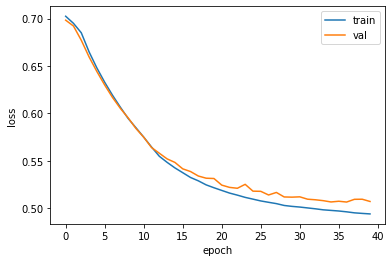

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

훈련 손실은 꾸준히 감소하고 있지만 검증 손실은 대략 스무 번째 에포크에서 감소가 둔해지고 있습니다. 적절한 에포크에서 훈련을 멈춘 것 같네요. 네, 성공입니다.

여기서 한 가지 생각할 점이 있습니다. 이 작업을 하기 위해서 입력 데이터를 원-핫 인코딩으로 변환했습니다. 원-핫 인코딩의 단점은 입력 데이터가 엄청 커진다는 것입니다. 실제로 train_seq 배열과 train_oh 배열의 nbytes 속성을 출력하여 크기를 확인해 보세요.

In [32]:
train_seq.nbytes, train_oh.nbytes

(8000000, 2400000000)

토큰 1개를 300차원으로 늘렸기 때문에 대략 300배가 커집니다! 훈련 데이터가 커질수록 더 문제가 될 것입니다. 다음 섹션에서 순환 신경망에 사용하는 더 좋은 단어 표현 방법을 알아보도록 하겠습니다.

## 단어 임베딩을 사용하기

순환 신경망에서 텍스트를 처리할 때 즐겨 사용하는 방법은 **단어 임베딩**word embedding입니다. 단어 임메딩은 각 단어를 고정된 크기의 실수 벡터로 바꾸어 줍니다. 예를 들면 다음 그림과 같습니다.

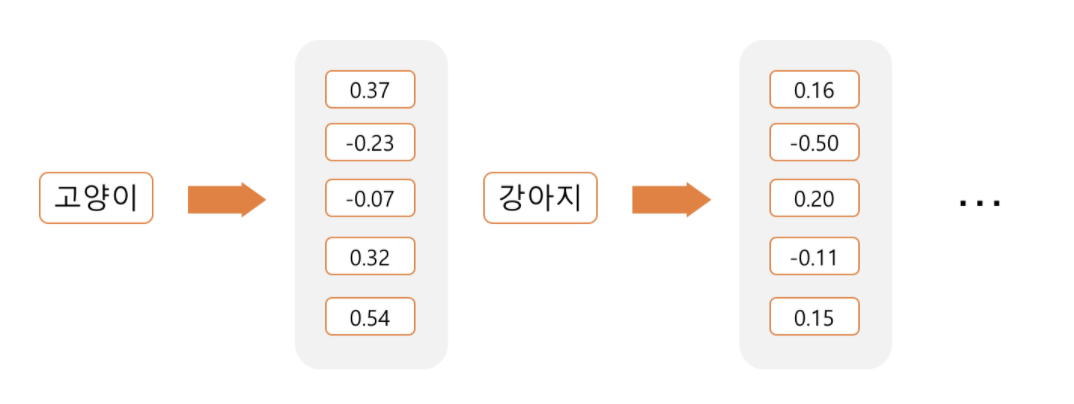

이런 단어 임베딩으로 만들어진 벡터는 원-하사 인코딩된 벡터보다 훨씬 의미있는 값으로 채워져 있기 때문에 자연어 처리에서 더 좋은 성능을 내는 경우가 많습니다. 케라스에서는 keras.layers 패키지 아래 Embedding 클래스로 임베딩 기능을 제공합니다. 이 클래스를 다른 층처럼 모델에 추가하면 처음에는 모든 벡터가 랜덤하게 초기화되지만 훈련을 통해 데이터에서 좋은 단어 임베딩을 학습합니다.

단어 임베딩의 장점은 입력으로 정수 데이터를 받는다는 것입니다. 이 때문에 메모리를 훨씬 효율적으로 사용할 수 있습니다.

Embedding 클래스를 SimpleRNN 층 앞에 추가한 두 번째 순환 신경망을 만들어 보겠습니다.

In [33]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(300, 16, input_length=100))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

Embedding 클래스의 첫 번째 매개변수(300)는 어휘 사전의 크기입니다.

두 번째 매개변수(16)는 임베딩 벡터의 크기입니다.

세 번째 input_length 매개변수는 입력 시퀀스의 길이입니다. 앞서 샘플의 길이를 100으로 맞추어 train_seq를 만들었습니다.

그다음 SimpleRNN 층과 Dense 층은 이전과 동일합니다.

In [34]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           4800      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 8)                 200       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 5,009
Trainable params: 5,009
Non-trainable params: 0
_________________________________________________________________


임베딩 층은 (100, ) 크기의 입력을 받아 (100, 16) 크기의 출력을 만듭니다.

In [35]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 6s 18ms/step - loss: 0.6898 - accuracy: 0.5323 - val_loss: 0.6699 - val_accuracy: 0.5960
Epoch 2/100
313/313 [==============================] - 5s 17ms/step - loss: 0.6449 - accuracy: 0.6546 - val_loss: 0.6309 - val_accuracy: 0.6704
Epoch 3/100
313/313 [==============================] - 5s 17ms/step - loss: 0.6193 - accuracy: 0.6952 - val_loss: 0.6143 - val_accuracy: 0.6992
Epoch 4/100
313/313 [==============================] - 5s 17ms/step - loss: 0.6012 - accuracy: 0.7138 - val_loss: 0.6055 - val_accuracy: 0.6998
Epoch 5/100
313/313 [==============================] - 5s 17ms/step - loss: 0.5868 - accuracy: 0.7268 - val_loss: 0.5879 - val_accuracy: 0.7182
Epoch 6/100
313/313 [==============================] - 5s 17ms/step - loss: 0.5747 - accuracy: 0.7345 - val_loss: 0.5743 - val_accuracy: 0.7292
Epoch 7/100
313/313 [==============================] - 5s 17ms/step - loss: 0.5636 - accuracy: 0.7411 - val_loss: 0.5693 - val_accuracy:

출력 결과를 보면 원-핫 인코딩을 사용한 모델과 비슷한 성능을 냈습니다. 반면에 순환층의 가중치 개수는 훨씬 작고 훈련 세트 크기도 훨씬 줄어들었습니다.

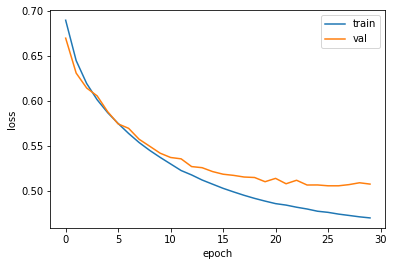

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

검증 손실이 더 감소되지 않아 훈련이 적절히 조기 종료된 것 같습니다. 이에 비해 훈련 손실은 계속 감소합니다. 이를 더 개선할 방법이 있는지 다음 절에서 알아보겠습니다.

## 마무리

### 핵심 포인트

- **말뭉치**: 자연어 처리에서 사용하는 텍스트 데이터의 모음, 즉 훈련 데이터셋
- **토큰**: 텍스트에서 공백으로 구분되는 문자열
- **원-핫 인코딩**: 어떤 클래스에 해당하는 원소만 1이고 나머지는 모두 0인 벡터
- **단어 임베딩**: 정수로 변환된 토큰을 비교적 작은 크기의 실수 밀집 벡터로 변환. 이런 밀집 벡터는 단어 사이의 관계를 표현할 수 있기 때문에 자연어 처리에서 좋은 성능 발휘

### 핵심 패키지와 함수

#### TensorFlow

- **pad_sequences()**: 시퀀스 길이 맞추기 위해 패딩 추가. 이 함수는 (샘플 개수, 타임스텝 개수) 크기의 2차원 배열을 기대.   
  maxlen 매개변수로 원하는 시퀀스 길이 지정. 이 값보다 긴 시퀀스는 잘리고 짧은 시퀀스는 패딩됨. 이 매개변수를 지정하지 않으면 가장 긴 시퀀스의 길이가 됨   
  padding 매개변수는 패딩을 추가할 위치 지정. 기본값 'pre'는 시퀀스 앞 패딩 추가, 'post'는 시퀀스 뒤 패딩 추가   
  truncating 매개변수는 긴 시퀀스에서 잘라버릴 위치 지정. 기본값 'pre'는 시퀀스 앞부분 잘라내고 'post'는 시퀀스 뒷부분 잘라냄   
- **to_categorical()**: 정수 시퀀스를 원-핫 인코딩으로 변환.   
  num_classes 매개변수에서 클래스 개수 지정. 지정하지 않으면 데이터에서 자동으로 찾음   
- **SimpleRNN**: 케라스의 기본 순환층 클래스   
  첫 번째 매개변수에 뉴런 개수 지정   
  activation 매개변수에서 활성화 함수 지정. 기본값 'tanh'   
  dropout 매개변수에서 입력에 대한 드롭아웃 비율 지정   
  return_sequences 매개변수에서 모든 타임스텝의 은닉 상태 출력 결정. 기본값 False   
- **Embedding**: 단어 임베딩을 위한 클래스   
  첫 번째 매개변수에서 어휘 사전 크기 지정   
  두 번째 매개변수에서 Embedding 층이 출력할 밀집 벡터 크기 지정
  input_length 매개변수에서 입력 시퀀스의 길이 지정. 이 매개변수는 Embedding 층 바로 뒤에 Flatten 이나 Dense 클래스가 올때 꼭 필요